In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm
import shap
import datetime as dt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score, auc
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
df_items = pd.read_csv("final_data/orders_items.csv", index_col=0)
df_reviews = pd.read_csv("final_data/order_reviews.csv", index_col=0)
df_orders = pd.read_csv("final_data/orders.csv", index_col=0)
df_products = pd.read_csv("final_data/products.csv", index_col=0)
df_geolocation = pd.read_csv("final_data/geolocation.csv", index_col=0)
df_sellers = pd.read_csv("final_data/sellers.csv", index_col=0)
df_payments = pd.read_csv("final_data/order_payments.csv", index_col=0)
df_customers = pd.read_csv("final_data/customers.csv", index_col=0)
df_category = pd.read_csv("final_data/product_category_name_translation.csv", index_col=0)

df_orders.reset_index(inplace=True)
df_orders.dropna(inplace=True)
df_orders = df_orders[df_orders['order_status']=='delivered']
df_customers.reset_index(inplace=True)
df_items.drop(columns=['shipping_limit_date_1', 'price_2', 'freight_value_3'], inplace=True)
df_items.columns = ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
df_items.dropna(inplace=True)

dataset_11 = (
    df_customers
    .merge(df_orders, on='customer_id')
    .merge(df_items, on='order_id')
    .merge(df_products, on='product_id')
    .merge(df_sellers, on='seller_id')
    .merge(df_reviews, on='order_id')
)

dataset_11 = dataset_11[['customer_unique_id', 'price', 'freight_value', 
                       'order_purchase_timestamp', 'order_delivered_customer_date', 
                       'product_category_name', 'review_score', 'order_id', 
                       'review_comment_message', 'customer_city']]  # по итогу сырые признаки вот такие используются

dataset_11['order_purchase_timestamp'] = pd.to_datetime(dataset_11['order_purchase_timestamp'])
dataset_11['order_delivered_customer_date'] = pd.to_datetime(dataset_11['order_delivered_customer_date'])

# latest_purchase_date = dataset_11['order_purchase_timestamp'].max() + dt.timedelta(days=1)
# cutoff_date = latest_purchase_date - dt.timedelta(days=60)

In [3]:
dataset_11.fillna('-', inplace=True)
dataset_11.isna().sum()

customer_unique_id               0
price                            0
freight_value                    0
order_purchase_timestamp         0
order_delivered_customer_date    0
product_category_name            0
review_score                     0
order_id                         0
review_comment_message           0
customer_city                    0
dtype: int64

In [4]:
def prepare_churn_dataset_v4(df, predict_days=60, churn_days=120, min_orders=1):
    """
    Готовит датасет для обучения модели оттока клиентов, улучшенная версия без встроенных преобразований.
    
    df — датафрейм с заказами
    predict_days — сколько последних дней считаем "предсказуемым будущим"
    churn_days — сколько дней без заказов считаем оттоком
    min_orders — минимальное кол-во заказов, чтобы участвовать в обучении
    
    Возвращает:
        train_df — для обучения (с меткой y)
        predict_df — для прогноза (без y)
    """
    # Убедимся, что дата в нужном формате
    df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
    df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
    
    # Последняя дата в данных
    last_date = df["order_purchase_timestamp"].max()
    
    # Отсечки
    cutoff_predict = last_date - dt.timedelta(days=predict_days)
    cutoff_churn = last_date - dt.timedelta(days=churn_days)

    df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
    
    # Агрегация по клиенту с дополнительными признаками
    agg = df.groupby("customer_unique_id").agg(
        latest_order=('order_purchase_timestamp', 'max'),
        mean_delivery_time=('delivery_time', 'mean'),
        n_categories=('product_category_name', 'nunique'),
        n_orders=('order_id', 'nunique'),
        avg_price=('price', 'mean'),
        avg_freight=('freight_value', 'mean'),
        avg_review=('review_score', 'mean'),
        most_common_category=('product_category_name', lambda x: x.mode()[0]),
        most_common_city=('customer_city', lambda x: x.mode()[0])
    ).reset_index()
    
    # Фильтруем только клиентов с нужным кол-вом заказов
    agg = agg[agg["n_orders"] >= min_orders].copy()

    # Назначаем группы
    agg["group"] = "predict"
    agg.loc[(agg["latest_order"] < cutoff_predict) & (agg["latest_order"] >= cutoff_churn), "group"] = "train"
    agg.loc[(agg["latest_order"] < cutoff_churn), "group"] = "churned"
    
    # Целевая переменная
    agg["y"] = None
    agg.loc[agg["group"] == "train", "y"] = 0
    agg.loc[agg["group"] == "churned", "y"] = 1
    agg.drop(columns='latest_order', inplace=True)
    
    # Отдельно train и predict
    train_df = agg[agg["group"].isin(["train", "churned"])].copy()
    predict_df = agg[agg["group"] == "predict"].copy()
    
    return train_df.set_index('customer_unique_id').drop(columns='group'), predict_df.set_index('customer_unique_id').drop(columns='group')

In [5]:
train_df, predict_df = prepare_churn_dataset_v4(dataset_11)
train_df.head()

mean_delivery_time  n_categories  \
customer_unique_id                                                       
0000366f-3b9a-7992-bf8c-76cfdf3221e2                 6.0             1   
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f                 3.0             1   
0000f46a-3911-fa3c-0805-444483337064                25.0             1   
0000f6cc-b074-5a6a-4b88-665a16c9f078                20.0             1   
0004aac8-4e0d-f4da-2b14-7fca70cf8255                13.0             1   

                                      n_orders  avg_price  avg_freight  \
customer_unique_id                                                       
0000366f-3b9a-7992-bf8c-76cfdf3221e2         1     129.90        12.00   
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f         1      18.90         8.29   
0000f46a-3911-fa3c-0805-444483337064         1      69.00        17.22   
0000f6cc-b074-5a6a-4b88-665a16c9f078         1      25.99        17.63   
0004aac8-4e0d-f4da-2b14-7fca70cf8255         1     180.00        16.89   

                                      avg_review most_common_category  \
customer_unique_id                                                      
0000366f-3b9a-7992-bf8c-76cfdf3221e2         5.0      cama_mesa_banho   
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f         4.0         beleza_saude   
0000f46a-3911-fa3c-0805-444483337064         3.0            papelaria   
0000f6cc-b074-5a6a-4b88-665a16c9f078         4.0            telefonia   
0004aac8-4e0d-f4da-2b14-7fca70cf8255         5.0            telefonia   

                                     most_common_city  y  
customer_unique_id                                        
0000366f-3b9a-7992-bf8c-76cfdf3221e2          cajamar  0  
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f           osasco  0  
0000f46a-3911-fa3c-0805-444483337064         sao jose  1  
0000f6cc-b074-5a6a-4b88-665a16c9f078            belem  1  
0004aac8-4e0d-f4da-2b14-7fca70cf8255         sorocaba  1

In [6]:
X, y = train_df.drop(columns=['y']), train_df['y'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

<Axes: >

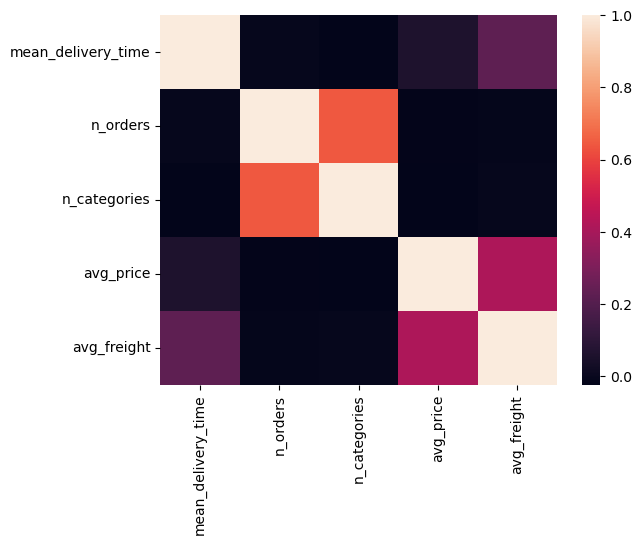

In [7]:
sns.heatmap(X_train[['mean_delivery_time', 'n_orders', 'n_categories', 'avg_price', 'avg_freight']].corr())

In [8]:
X.columns

Index(['mean_delivery_time', 'n_categories', 'n_orders', 'avg_price',
       'avg_freight', 'avg_review', 'most_common_category',
       'most_common_city'],
      dtype='object')

array([[<Axes: title={'center': 'mean_delivery_time'}>,
        <Axes: title={'center': 'n_orders'}>,
        <Axes: title={'center': 'n_categories'}>],
       [<Axes: title={'center': 'avg_price'}>,
        <Axes: title={'center': 'avg_freight'}>, <Axes: >]], dtype=object)

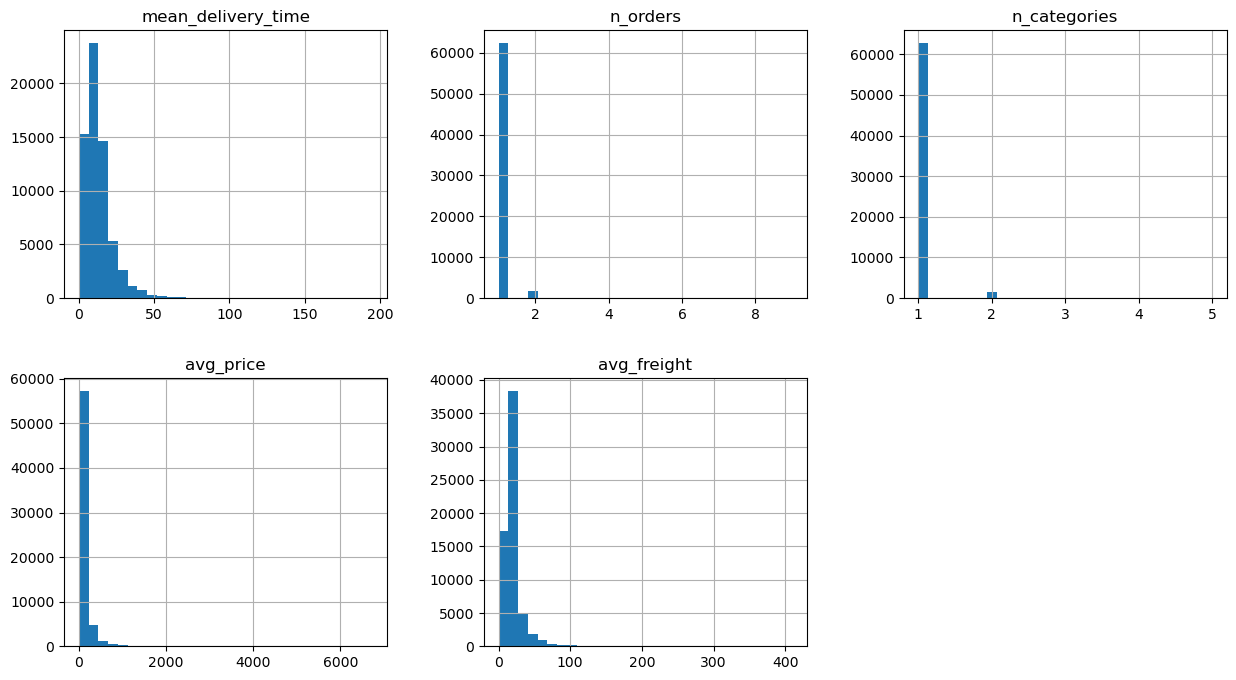

In [9]:
X_train[['mean_delivery_time', 'n_orders', 'n_categories', 'avg_price', 'avg_freight']].hist(bins=30, figsize=(15, 8), layout=(2, 3))

In [10]:
numeric_features = ['mean_delivery_time', 'n_orders', 'n_categories', 'avg_price', 'avg_freight']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ['most_common_category', 'most_common_city']
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model_lgbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    is_unbalance=True,          # Auto-balance classes
    metric='aucpr',            # Use AUC-PR for imbalance
    n_estimators=200,
    learning_rate=0.05,
    min_child_samples=50,      # Reduce overfitting
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=0.1             # L2 regularization
)

clf_lgbm = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model_lgbm)]
)

In [11]:
clf_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 54317, number of negative: 9968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 64285, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.844940 -> initscore=1.695457
[LightGBM] [Info] Start training from score 1.695457


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['mean_delivery_time',
                                                   'n_orders', 'n_categories',
                                                   'avg_price',
                                                   'avg_freight']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x000001F497119D00>))]),
                                                  ['most_common_category',
                                                   'most_common_city'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True, learning_rate=0.05,
                                metric='aucpr', min_child_samples=50,
                                n_estimators=200, objective='binary',
                                reg_alpha=0.1, reg_lambda=0.1))])

Classification report:
               precision    recall  f1-score   support

           0       0.36      0.80      0.49      2462
           1       0.95      0.74      0.83     13610

    accuracy                           0.75     16072
   macro avg       0.66      0.77      0.66     16072
weighted avg       0.86      0.75      0.78     16072

AUC-ROC: 0.8489660473286534


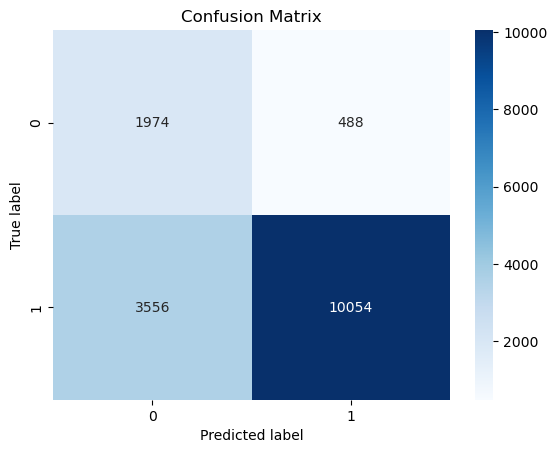

In [12]:
y_pred = clf_lgbm.predict(X_test)
y_proba = clf_lgbm.predict_proba(X_test)[:, 1]  # вероятности класса 1 (ушёл)

print("Classification report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

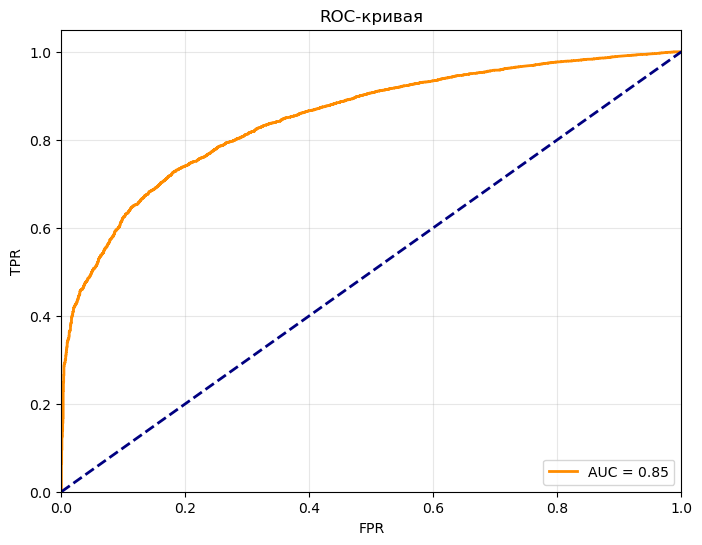

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 4. Строим график
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\Dmitriy\AppData\Local\Temp\ipykernel_31452\3041775022.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x="importance", y="feature", palette="viridis")


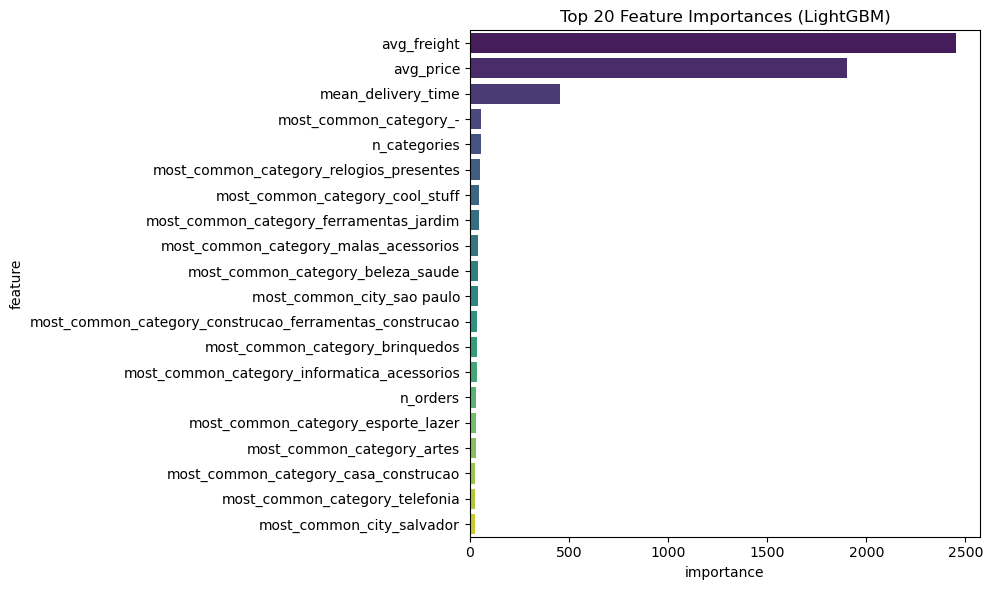

In [14]:
num_features = clf_lgbm.named_steps["preprocessor"].transformers_[0][2]

cat_transformer = clf_lgbm.named_steps["preprocessor"].named_transformers_["cat"]
ohe = cat_transformer.named_steps["encoder"]
all_cat_feature_names = ohe.get_feature_names_out(categorical_features)

selector = cat_transformer.named_steps["selector"]
selected_cat_feature_names = all_cat_feature_names[selector.get_support()]

all_feature_names = np.concatenate([num_features, selected_cat_feature_names])

importances = clf_lgbm.named_steps["classifier"].feature_importances_

feat_imp_df = (
    pd.DataFrame({"feature": all_feature_names, "importance": importances})
    .sort_values(by="importance", ascending=False)
)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(20), x="importance", y="feature", palette="viridis")
plt.title("Top 20 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

100%|===================| 64246/64285 [16:16<00:00]        

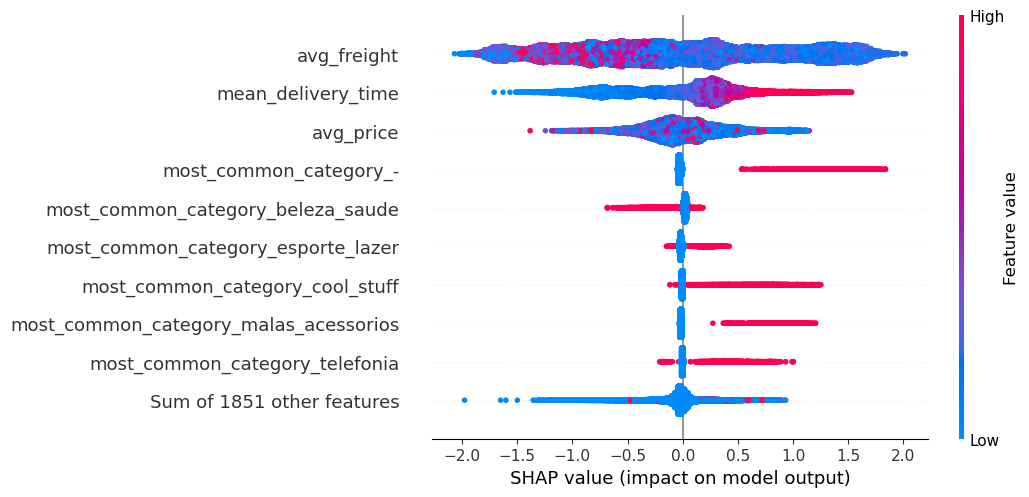

In [15]:
numeric_features = ['mean_delivery_time', 'n_orders', 'n_categories', 'avg_price', 'avg_freight']
ohe = clf_lgbm.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
selector = clf_lgbm.named_steps['preprocessor'].named_transformers_['cat'].named_steps['selector']

cat_ohe_names = ohe.get_feature_names_out(['most_common_category', 'most_common_city'])
selected_cat_names = cat_ohe_names[selector.get_support()]
final_feature_names = np.concatenate([numeric_features, selected_cat_names])

# Step 2: Transform input data and convert to dense float32
X_transformed = clf_lgbm.named_steps['preprocessor'].transform(X_train)
X_transformed = X_transformed.toarray().astype(np.float32)  # Convert from sparse to dense

# Step 3: SHAP explainer
explainer = shap.Explainer(clf_lgbm.named_steps['classifier'], X_transformed, feature_names=final_feature_names)
shap_values = explainer(X_transformed, check_additivity=False)

# Step 4: SHAP summary plot
shap.plots.beeswarm(shap_values)

In [16]:
predict_churn = clf_lgbm.predict(predict_df)
predicted_info = pd.DataFrame(data=predict_churn,
                              index=predict_df.index,
                              columns=['prediction'])
predicted_info

prediction
customer_unique_id                              
000ec5bf-f359-e1c0-ad76-a81a45cb598f           0
000fbf04-73c1-0fc1-ab6f-8d2d286ce20c           0
0015752e-0799-02b1-2cd0-0b9b7596276b           0
00172711-b30d-52ee-a8b3-13a7f2cced02           0
001928b5-6157-5b28-21c9-2254a2327d06           0
...                                          ...
ffec490a-b531-184a-483e-fe2eedd68908           0
ffee94d5-48ce-f05b-146d-825a7648dab4           0
fff3e1d7-bc75-f11d-c767-0619b2e61840           1
fff5eb49-18b2-bf4b-2da4-76788d42051c           0
fff96bc5-86f7-8b1f-070d-a28c4977e810           0

[12376 rows x 1 columns]

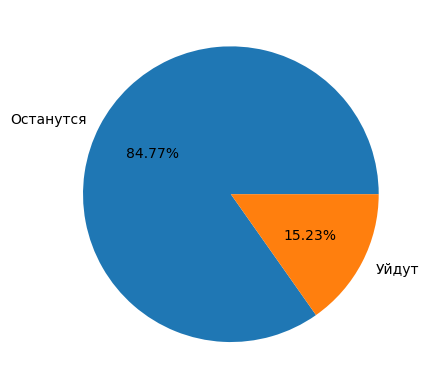

In [17]:
plt.pie(predicted_info['prediction'].value_counts().values,
        labels=['Останутся', 'Уйдут'],
        autopct='%1.2f%%')
plt.show()

In [18]:
predicted_info.to_csv('preds.csv')

In [19]:
joblib.dump(clf_lgbm, 'app_model.joblib')

['app_model.joblib']

In [20]:
analyse_preds = predict_df.merge(predicted_info, right_index=True, left_index=True)

In [21]:
analyse_preds.head()

mean_delivery_time  n_categories  \
customer_unique_id                                                       
000ec5bf-f359-e1c0-ad76-a81a45cb598f                 6.0             1   
000fbf04-73c1-0fc1-ab6f-8d2d286ce20c                 8.0             2   
0015752e-0799-02b1-2cd0-0b9b7596276b                 3.0             1   
00172711-b30d-52ee-a8b3-13a7f2cced02                10.0             1   
001928b5-6157-5b28-21c9-2254a2327d06                 6.0             2   

                                      n_orders  avg_price  avg_freight  \
customer_unique_id                                                       
000ec5bf-f359-e1c0-ad76-a81a45cb598f         1     14.960        12.79   
000fbf04-73c1-0fc1-ab6f-8d2d286ce20c         1     71.450        19.14   
0015752e-0799-02b1-2cd0-0b9b7596276b         1     29.900         7.51   
00172711-b30d-52ee-a8b3-13a7f2cced02         1     74.500        47.57   
001928b5-6157-5b28-21c9-2254a2327d06         1     68.445        13.96   

                                      avg_review most_common_category  \
customer_unique_id                                                      
000ec5bf-f359-e1c0-ad76-a81a45cb598f         5.0     eletrodomesticos   
000fbf04-73c1-0fc1-ab6f-8d2d286ce20c         5.0           brinquedos   
0015752e-0799-02b1-2cd0-0b9b7596276b         5.0     malas_acessorios   
00172711-b30d-52ee-a8b3-13a7f2cced02         4.0            papelaria   
001928b5-6157-5b28-21c9-2254a2327d06         2.0      cama_mesa_banho   

                                       most_common_city     y  prediction  
customer_unique_id                                                         
000ec5bf-f359-e1c0-ad76-a81a45cb598f  salto de pirapora  None           0  
000fbf04-73c1-0fc1-ab6f-8d2d286ce20c         indaiatuba  None           0  
0015752e-0799-02b1-2cd0-0b9b7596276b          sao paulo  None           0  
00172711-b30d-52ee-a8b3-13a7f2cced02             jequie  None           0  
001928b5-6157-5b28-21c9-2254a2327d06          sao paulo  None           0

In [22]:
active_preds = analyse_preds[analyse_preds['prediction']==1]
inactive_preds = analyse_preds[analyse_preds['prediction']==0]

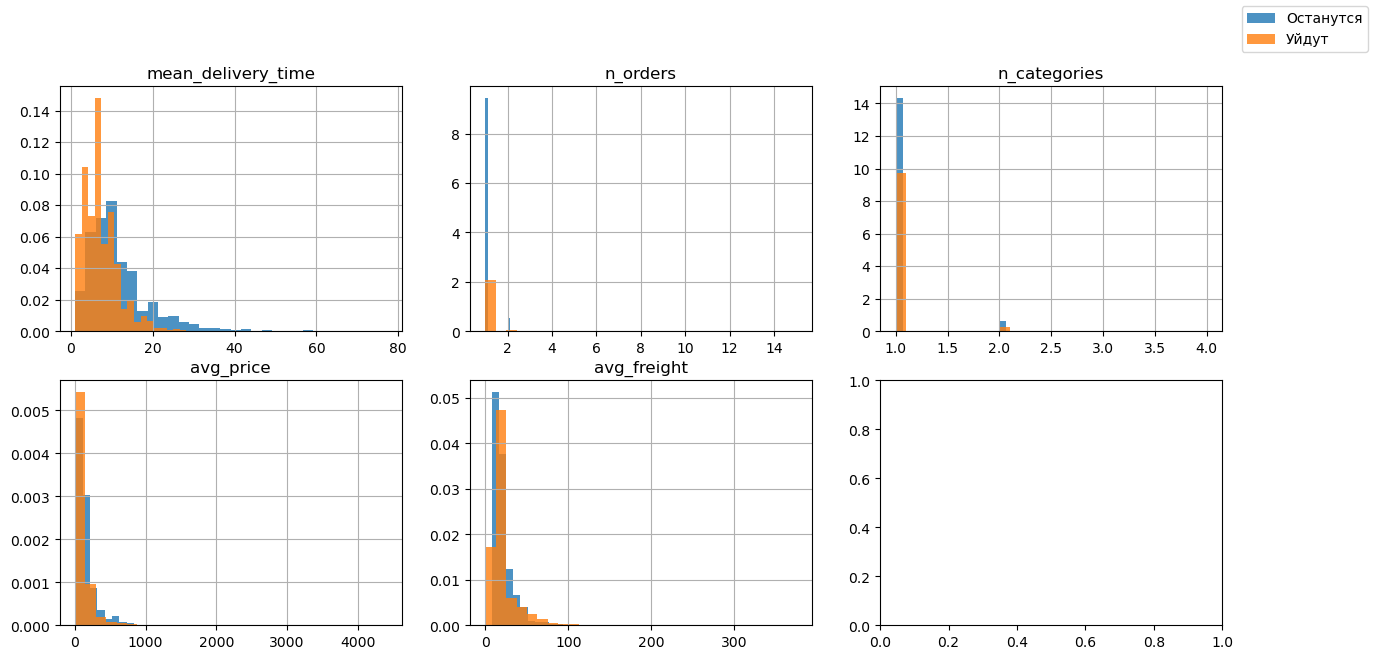

In [23]:
fig, ax = plt.subplots(2,3, figsize=(15, 7))
cols = ['mean_delivery_time', 'n_orders', 'n_categories', 'avg_price', 'avg_freight']
k = 0

for i in range(2):
    for j in range(3):
        ax[i, j].hist(active_preds[cols[k]],bins=30, density=True, alpha=0.8)
        ax[i, j].hist(inactive_preds[cols[k]],bins=30, density=True, alpha=0.8)
        ax[i, j].set_title(cols[k])
        ax[i, j].grid()
        k += 1
        if k == 5:
            break
fig.legend(['Останутся', 'Уйдут'])

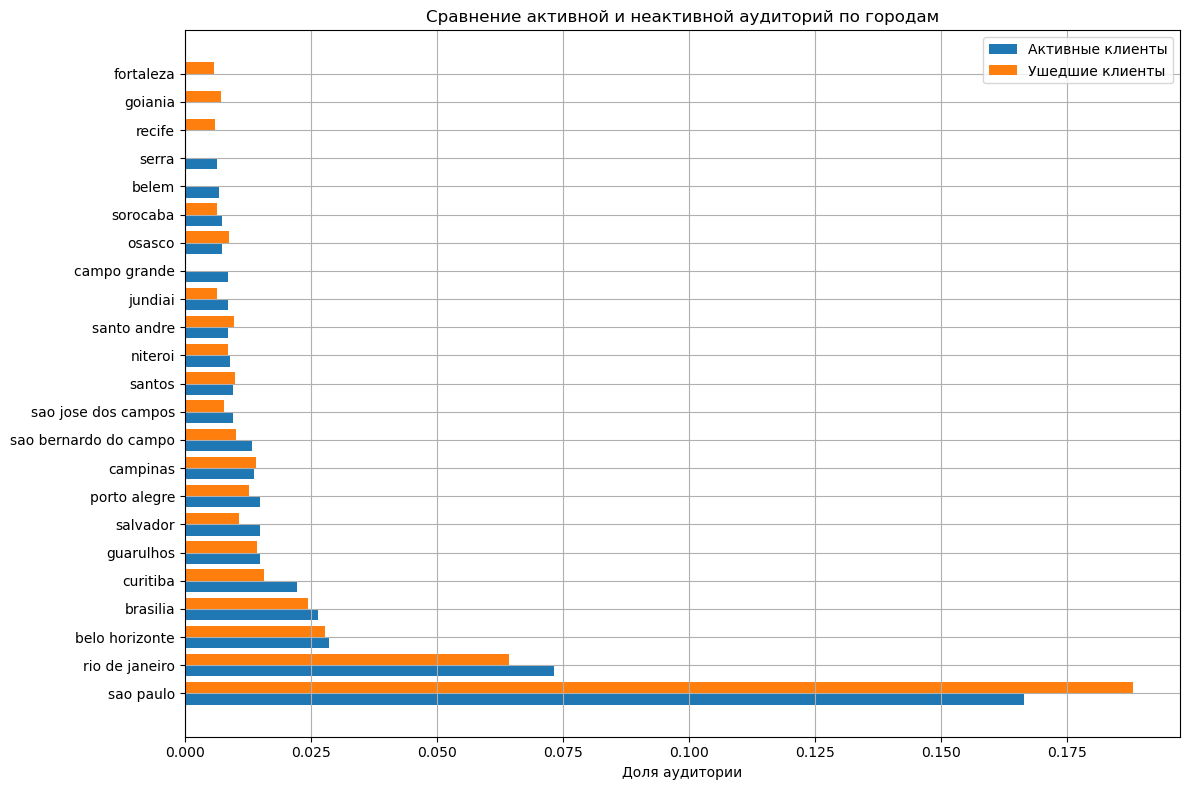

In [24]:
top_active = active_preds['most_common_city'].value_counts().head(20)
top_inactive = inactive_preds['most_common_city'].value_counts().head(20)
common_cities = set(top_active.index).union(set(top_inactive.index))

active_normalized = (active_preds[active_preds['most_common_city'].isin(common_cities)]['most_common_city'].value_counts().head(20) / len(active_preds))
inactive_normalized = (inactive_preds[inactive_preds['most_common_city'].isin(common_cities)]['most_common_city'].value_counts().head(20) / len(inactive_preds))

combined = active_normalized.to_frame('active').join(inactive_normalized.to_frame('inactive'), how='outer').fillna(0)
combined = combined.sort_values('active', ascending=False)  # Sort for better visualization
combined_english = (
    combined
    .merge(df_category, left_index=True, right_on='product_category_name', how='left')
    .reset_index()
    .set_index('product_category_name_english'))

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(combined))

bars1 = ax.barh(index, combined['active'], bar_width, label='Активные клиенты')
bars2 = ax.barh(index + bar_width, combined['inactive'], bar_width, label='Ушедшие клиенты')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(combined.index)
ax.set_xlabel('Доля аудитории')
ax.set_title('Сравнение активной и неактивной аудиторий по городам')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

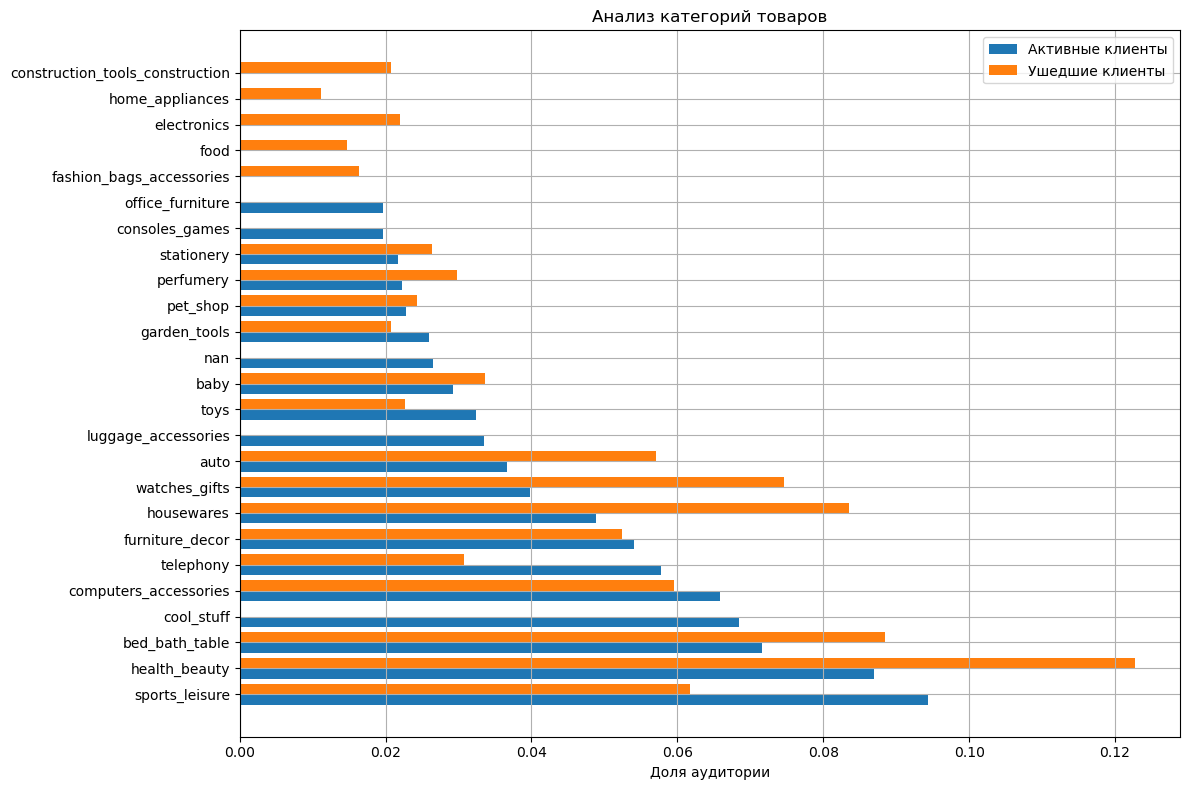

In [25]:
top_active = active_preds['most_common_category'].value_counts().head(20)
top_inactive = inactive_preds['most_common_category'].value_counts().head(20)
common_cities = set(top_active.index).union(set(top_inactive.index))

active_normalized = (active_preds[active_preds['most_common_category'].isin(common_cities)]['most_common_category'].value_counts().head(20) / len(active_preds))
inactive_normalized = (inactive_preds[inactive_preds['most_common_category'].isin(common_cities)]['most_common_category'].value_counts().head(20) / len(inactive_preds))

combined = active_normalized.to_frame('active').join(inactive_normalized.to_frame('inactive'), how='outer').fillna(0)
combined = combined.sort_values('active', ascending=False)  # Sort for better visualization
combined_english = (
    combined
    .merge(df_category, left_index=True, right_on='product_category_name', how='left')
    .reset_index()
    .set_index('product_category_name_english'))

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(combined))

bars1 = ax.barh(index, combined['active'], bar_width, label='Активные клиенты')
bars2 = ax.barh(index + bar_width, combined['inactive'], bar_width, label='Ушедшие клиенты')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(combined_english.index)
ax.set_xlabel('Доля аудитории')
ax.set_title('Анализ категорий товаров')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()